In [12]:
import pandas as pd
#aabbccdee
df = pd.read_csv("water_potability.csv")

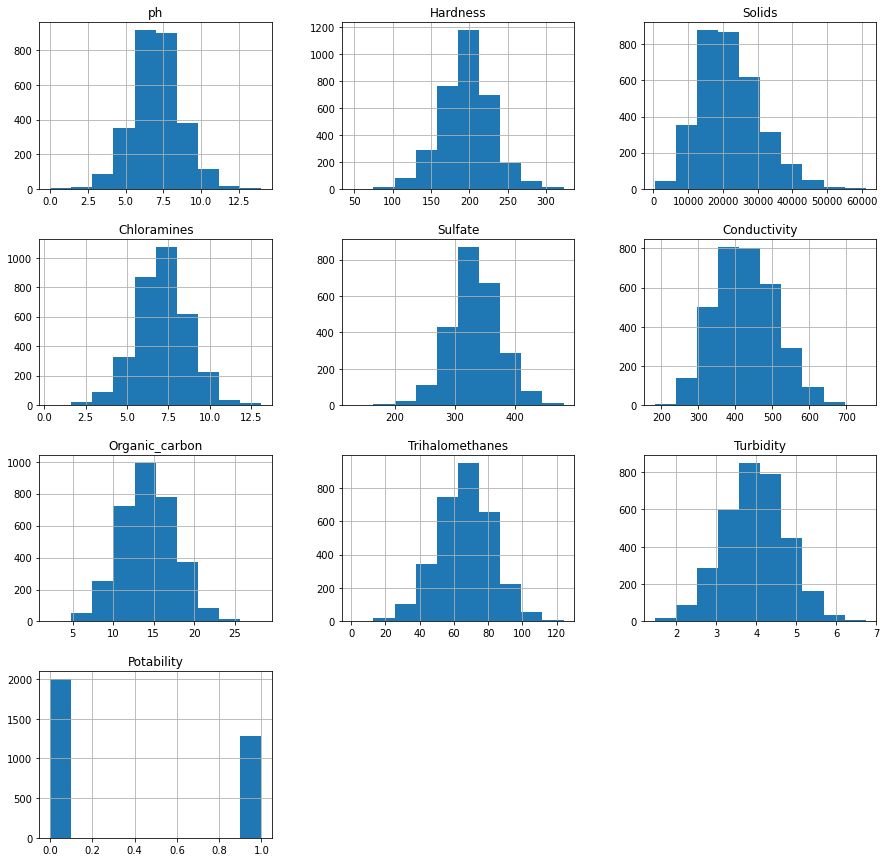

In [13]:
from matplotlib import pyplot as plt

df.hist(figsize=(15, 15))
plt.show()

<AxesSubplot:>

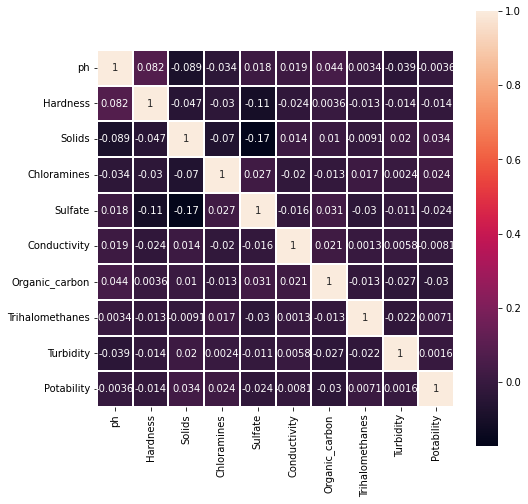

In [14]:
from numpy import true_divide
import seaborn as sns

plt.figure(figsize=(8, 8))
sns.heatmap(df.corr(), annot=True, linewidths=1, square=True)

In [15]:
df.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [16]:
df["ph"].fillna(value=df["ph"].median(), inplace=True)
df["Sulfate"].fillna(value=df["Sulfate"].median(), inplace=True)
df["Trihalomethanes"].fillna(value=df["Trihalomethanes"].median(), inplace=True)
df.isnull().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

lr=LogisticRegression()
tree=DecisionTreeClassifier()
forest=RandomForestClassifier()
svm=SVC()
knn=KNeighborsClassifier()

{'max_depth': 7, 'max_features': 9}
0.6431297709923663

DecisionTree Accuracy: 0.6463414634146342

DecisionTree Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.86      0.75       412
           1       0.55      0.28      0.37       244

    accuracy                           0.65       656
   macro avg       0.61      0.57      0.56       656
weighted avg       0.62      0.65      0.61       656



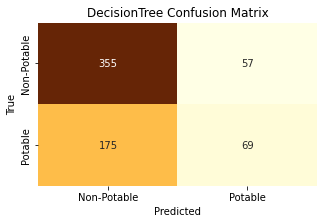

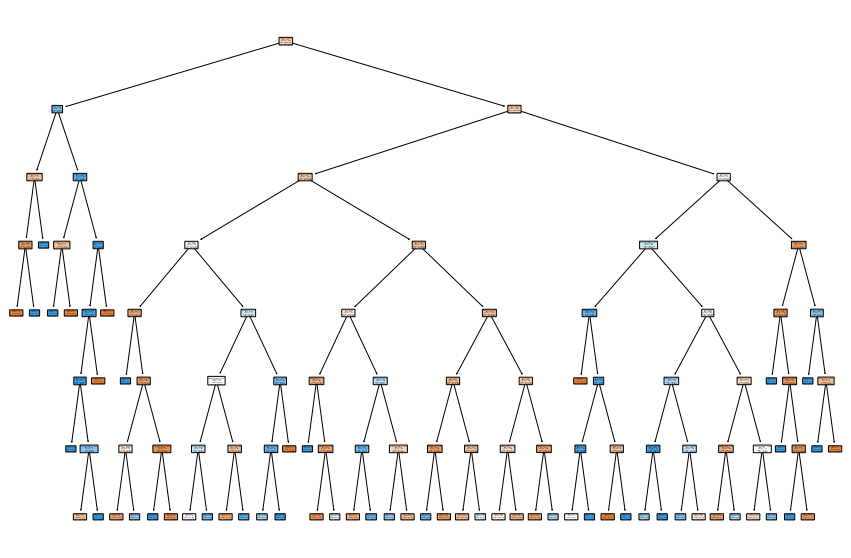

Cross-Validation Scores: [0.57926829 0.62442748 0.63816794 0.58167939 0.64274809]
Mean Accuracy: 0.6132582386892571


In [18]:
#決策樹
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import export_text
from sklearn.tree import plot_tree
import seaborn as sns
import matplotlib.pyplot as plt

# 填充缺失值
df["ph"].fillna(value=df["ph"].median(), inplace=True)
df["Sulfate"].fillna(value=df["Sulfate"].median(), inplace=True)
df["Trihalomethanes"].fillna(value=df["Trihalomethanes"].median(), inplace=True)

# 切分特徵和目標變量
X = df.drop("Potability", axis=1)
y = df["Potability"]

# 切分訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_param={'max_depth':[i for i in range(1,101)],'max_features':[i for i in range(1, len(X.columns) + 1)]}
grid_search=GridSearchCV(DecisionTreeClassifier(),model_param,cv=5)
grid_search.fit(X_train,y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)
best_param=grid_search.best_params_

#建立決策樹模型
model = DecisionTreeClassifier(max_features=best_param['max_features'],max_depth=best_param['max_depth'])
model.fit(X_train, y_train)

#進行預測
y_pred = model.predict(X_test)

# 評估模型性能
accuracy = accuracy_score(y_test, y_pred)
print(f"\nDecisionTree Accuracy: {accuracy}\n")

# 分類報告
class_report = classification_report(y_test, y_pred)
print("DecisionTree Classification Report:")
print(class_report)

# 混淆矩陣
conf_matrix = confusion_matrix(y_test, y_pred)

# 使用Seaborn來繪製熱力圖
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlOrBr', cbar=False,
            xticklabels=["Non-Potable", "Potable"],
            yticklabels=["Non-Potable", "Potable"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('DecisionTree Confusion Matrix')
plt.show()

# 特徵名稱
feature_names = X.columns.tolist()

# 可視化決策樹
plt.figure(figsize=(15, 10))
plot_tree(model, feature_names=feature_names, class_names=["Non-Potable", "Potable"], filled=True, rounded=True)
plt.show()

from sklearn.model_selection import cross_val_score

# 交叉驗證
cross_val_scores = cross_val_score(model, X, y, cv=5)
print(f"Cross-Validation Scores: {cross_val_scores}")
print(f"Mean Accuracy: {cross_val_scores.mean()}")

{'n_neighbors': 16}
0.6473282442748092

KNN Accuracy: 0.6692073170731707

KNN Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.91      0.78       412
           1       0.63      0.27      0.37       244

    accuracy                           0.67       656
   macro avg       0.65      0.59      0.57       656
weighted avg       0.66      0.67      0.63       656



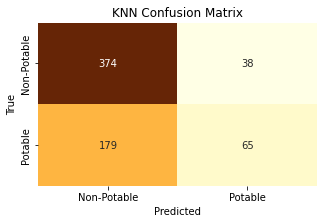


Cross-Validation Scores: [0.59146341 0.58931298 0.60916031 0.59389313 0.59083969]
Mean Accuracy: 0.594933904300875


In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt

# 填充缺失值
df["ph"].fillna(value=df["ph"].median(), inplace=True)
df["Sulfate"].fillna(value=df["Sulfate"].median(), inplace=True)
df["Trihalomethanes"].fillna(value=df["Trihalomethanes"].median(), inplace=True)

# 特徵和目標變數
X = df.drop('Potability', axis=1)
y = df['Potability']

# 切分資料集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 特徵標準化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 使用網格搜索尋找最佳K值
model_param = {'n_neighbors': range(1, 21)}
grid_search = GridSearchCV(KNeighborsClassifier(), model_param, cv=5)
grid_search.fit(X_train_scaled, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)
best_k = grid_search.best_params_['n_neighbors']

# 使用最佳K值擬合新的KNN模型
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train_scaled, y_train)

# 預測
y_pred_best = knn.predict(X_test_scaled)

# 評估模型性能
accuracy = accuracy_score(y_test, y_pred_best)
classification_rep = classification_report(y_test, y_pred_best)

# 分類報告
print(f'\nKNN Accuracy: {accuracy}\n')
print(f'KNN Classification Report:\n{classification_rep}')

# 使用Seaborn來繪製混淆矩陣
conf_matrix_best = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix_best, annot=True, fmt='d', cmap='YlOrBr', cbar=False,
            xticklabels=["Non-Potable", "Potable"],
            yticklabels=["Non-Potable", "Potable"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('KNN Confusion Matrix')
plt.show()

# 交叉驗證
cv_val_scores = cross_val_score(knn, X, y, cv=5)
print(f"\nCross-Validation Scores: {cv_val_scores}")
print(f"Mean Accuracy: {cv_val_scores.mean()}")

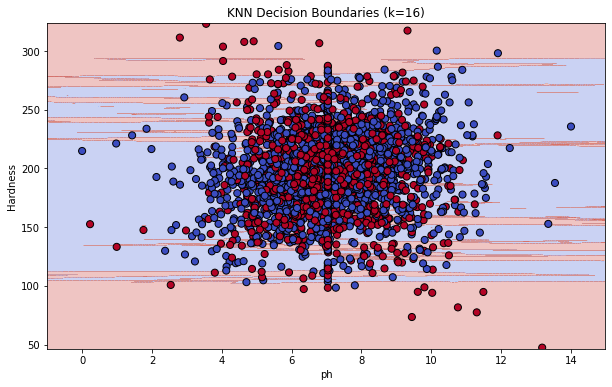

In [20]:
# 取前兩個特徵用於可視化
import numpy as np

X_2d = X[['ph', 'Hardness']]

# 設定模型和參數
knn_vis = KNeighborsClassifier(n_neighbors=best_k)

# 訓練模型
knn_vis.fit(X_2d, y)

# 繪製決策邊界
h = .02
x_min, x_max = X_2d.iloc[:, 0].min() - 1, X_2d.iloc[:, 0].max() + 1
y_min, y_max = X_2d.iloc[:, 1].min() - 1, X_2d.iloc[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = knn_vis.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# 繪製數據點和決策邊界
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.3)
plt.scatter(X_2d.iloc[:, 0], X_2d.iloc[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k', s=50)
plt.xlabel('ph')
plt.ylabel('Hardness')
plt.title(f'KNN Decision Boundaries (k={best_k})')
plt.show()
#12/14